<a href="https://colab.research.google.com/github/ivelin/canswim/blob/main/canswim_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an experimental attempt to implement growth stock indicators in support of CANSLIM style investors and traders.

Jupyter notebook housekeeping

In [505]:
pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.


In [506]:
# fix python path if working locally
#from utils import fix_pythonpath_if_working_locally
#
#fix_pythonpath_if_working_locally()
#%matplotlib inline



In [507]:

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Check whether GPU is available

In [508]:
import torch
torch.cuda.is_available()

False

Load data from prepared local csv files

In [509]:
from darts import TimeSeries
import pandas as pd


Load stock symbols

Load price history
* Past covariates

In [510]:
stocks_file = 'data/ibdgrowth_hist.csv.bz2'

In [511]:
# load into a dataframe with valid market calendar days
stocks_df = pd.read_csv(stocks_file, header=[0, 1], index_col=0)
stocks_df



BROS                                              \
                          Open       High        Low      Close  Adj Close   
Date                                                                         
1962-01-02 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-03 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-04 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-05 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-08 00:00:00        NaN        NaN        NaN        NaN        NaN   
...                        ...        ...        ...        ...        ...   
2024-01-05 00:00:00  30.900000  31.780001  30.799999  31.110001  31.110001   
2024-01-08 00:00:00  31.240000  31.500000  28.340000  29.690001  29.690001   
2024-01-09 00:00:00  29.469999  29.620001  28.590000  28.629999  28.629999   
2024-01-10 00:00:00  28.700001  29.760000  28.639999  29.480000  29.480000   
2024-01-11 00:00:00  29.510000  29.590000  28.230000  28.270100  28.270100   

                                 OBDC                         ...          CB  \
                        Volume   Open    High     Low  Close  ...         Low   
Date                                                          ...               
1962-01-02 00:00:00        NaN    NaN     NaN     NaN    NaN  ...         NaN   
1962-01-03 00:00:00        NaN    NaN     NaN     NaN    NaN  ...         NaN   
1962-01-04 00:00:00        NaN    NaN     NaN     NaN    NaN  ...         NaN   
1962-01-05 00:00:00        NaN    NaN     NaN     NaN    NaN  ...         NaN   
1962-01-08 00:00:00        NaN    NaN     NaN     NaN    NaN  ...         NaN   
...                        ...    ...     ...     ...    ...  ...         ...   
2024-01-05 00:00:00  1860100.0  14.97  15.025  14.915  14.96  ...  226.630005   
2024-01-08 00:00:00  3998600.0  14.96  15.100  14.910  15.08  ...  223.690002   
2024-01-09 00:00:00  2211900.0  15.04  15.150  14.990  15.06  ...  222.860001   
2024-01-10 00:00:00  1605100.0  15.08  15.160  15.035  15.05  ...  223.550003   
2024-01-11 00:00:00  1028658.0  15.05  15.080  14.835  15.05  ...  224.740005   

                                                               PHM  \
                          Close   Adj Close     Volume        Open   
Date                                                                 
1962-01-02 00:00:00         NaN         NaN        NaN         NaN   
1962-01-03 00:00:00         NaN         NaN        NaN         NaN   
1962-01-04 00:00:00         NaN         NaN        NaN         NaN   
1962-01-05 00:00:00         NaN         NaN        NaN         NaN   
1962-01-08 00:00:00         NaN         NaN        NaN         NaN   
...                         ...         ...        ...         ...   
2024-01-05 00:00:00  227.699997  227.699997  1439200.0   99.860001   
2024-01-08 00:00:00  226.199997  226.199997  1535500.0  102.330002   
2024-01-09 00:00:00  225.309998  225.309998  1293300.0  102.550003   
2024-01-10 00:00:00  225.250000  225.250000  1716800.0  104.709999   
2024-01-11 00:00:00  227.220001  227.220001   919674.0  103.940002   

                                                                                
                           High         Low       Close   Adj Close     Volume  
Date                                                                            
1962-01-02 00:00:00         NaN         NaN         NaN         NaN        NaN  
1962-01-03 00:00:00         NaN         NaN         NaN         NaN        NaN  
1962-01-04 00:00:00         NaN         NaN         NaN         NaN        NaN  
1962-01-05 00:00:00         NaN         NaN         NaN         NaN        NaN  
1962-01-08 00:00:00         NaN         NaN         NaN         NaN        NaN  
...                         ...         ...         ...         ...        ...  
2024-01-05 00:00:00  102.330002   99.860001  101.480003  101.480003  1601900.0  
2024-01

In [512]:
stocks_df.columns.levels[0]

Index(['AAON', 'ABBNY', 'ADSK', 'AEO', 'AER', 'AFYA', 'AGO', 'AIG', 'ALKS',
       'ALKT',
       ...
       'WSM', 'WTFC', 'XP', 'XYL', 'YELP', 'Z', 'ZG', 'ZION', 'ZS', 'ZTS'],
      dtype='object', length=309)

In [513]:
import random

# minimum amount of historical data required to train on a stock series
# stocks that are too new off IPOs, are not a good fit for training this model
min_samples = 1024

stocks_df.index = pd.to_datetime(stocks_df.index)

ticker_dict = {}
stock_tickers = stocks_df.columns.levels[0]
print(type(stock_tickers))


<class 'pandas.core.indexes.base.Index'>


In [514]:
print(list(stock_tickers))

['AAON', 'ABBNY', 'ADSK', 'AEO', 'AER', 'AFYA', 'AGO', 'AIG', 'ALKS', 'ALKT', 'ALLE', 'ALLY', 'ALTR', 'AMD', 'AMGN', 'AMK', 'AMP', 'AMPH', 'AMZN', 'ANET', 'ANF', 'AOS', 'APO', 'ARCO', 'ARES', 'ARM', 'AROC', 'ARVN', 'ASML', 'ASND', 'ASO', 'AVGO', 'AWI', 'AX', 'AXON', 'AXP', 'AZEK', 'AZTA', 'BAC', 'BAM', 'BCO', 'BK', 'BKNG', 'BLBD', 'BLD', 'BLDR', 'BLK', 'BLKB', 'BLX', 'BMI', 'BOH', 'BR', 'BROS', 'BSX', 'BURL', 'BX', 'CADE', 'CAH', 'CAMT', 'CARR', 'CAT', 'CB', 'CCL', 'CDRE', 'CELH', 'CHKP', 'CLS', 'CMG', 'CNM', 'COF', 'COIN', 'COLB', 'COLL', 'COST', 'CRBG', 'CRH', 'CRM', 'CRS', 'CRSP', 'CRWD', 'CSWC', 'CYBR', 'DASH', 'DB', 'DBX', 'DDOG', 'DECK', 'DFH', 'DHI', 'DKS', 'DOCN', 'DOCU', 'DT', 'DUOL', 'DV', 'DXCM', 'EDU', 'ELF', 'EME', 'ENSG', 'ERIE', 'ERJ', 'ESTC', 'ETN', 'EWBC', 'EXPE', 'FBIN', 'FERG', 'FI', 'FICO', 'FITB', 'FIX', 'FLEX', 'FLR', 'FLT', 'FNF', 'FOR', 'FOUR', 'FROG', 'FRPT', 'FRSH', 'FSS', 'FTAI', 'GBDC', 'GCT', 'GDDY', 'GE', 'GEL', 'GEN', 'GFF', 'GLOB', 'GOOG', 'GOOGL', 'GPK'

In [515]:
print(stock_tickers[0])

AAON


In [516]:
# use only a small subset of stocks while testing impact of covariates on model performance
stock_tickers = random.sample(list(stock_tickers), 10)
for t in stock_tickers:
    stock_full_hist = stocks_df[t].dropna()
    if len(stock_full_hist.index) >= min_samples:
        # we only need Adj Close which takes into account dividends and splits
        ticker_dict[t] = stock_full_hist.drop(columns=['Close'])
        print(f'ticker: {t}')
        print(f'ticker historic data: {ticker_dict[t]}')


ticker: EXPE
ticker historic data:                   Open        High         Low   Adj Close     Volume
Date                                                                 
2005-07-21   48.220001   49.200001   47.840000   31.640823   109200.0
2005-07-22   49.240002   49.799999   47.900002   32.747349    56800.0
2005-07-25   49.799999   49.799999   48.299999   31.930624    39600.0
2005-07-26   48.700001   48.700001   47.500000   31.614489   102450.0
2005-07-27   48.000000   48.240002   47.299999   31.706694    98100.0
...                ...         ...         ...         ...        ...
2024-01-05  144.279999  147.550003  144.279999  146.320007  1579600.0
2024-01-08  147.110001  150.470001  146.029999  149.679993  2333900.0
2024-01-09  148.610001  153.160004  148.570007  152.729996  2094900.0
2024-01-10  152.029999  154.779999  151.350006  151.850006  1566700.0
2024-01-11  151.550003  153.089996  150.270004  151.029999  1239457.0

[4651 rows x 5 columns]
ticker: TJX
ticker historic da

In [517]:
ticker_dict.keys()

dict_keys(['EXPE', 'TJX', 'WTFC', 'EWBC', 'MMYT', 'MBWM', 'BLD', 'GLOB', 'NFLX', 'PWR'])

In [518]:
type(list(ticker_dict.keys()))

list

In [519]:
list(ticker_dict.keys())[0]

'EXPE'

In [520]:
# type(raw_df.index)

In [521]:
# check for missing values
# raw_df.shape[0] - raw_df.dropna().shape[0]

In [522]:
# raw_df

In [523]:

# series = TimeSeries.from_csv('data/market_data.csv', time_col='Date')

ticker_series = {ticker: TimeSeries.from_dataframe(ticker_dict[ticker], freq='B') for ticker in ticker_dict.keys()}
ticker_series

# series = TimeSeries.from_dataframe(raw_df, freq='B')

# raw_df = pd.read_csv(data_file_name, parse_dates=['Date'], index_col=['Date'])

# series = TimeSeries.from_csv(data_file_name, time_col='Date', freq='B')


{'EXPE': <TimeSeries (DataArray) (Date: 4821, component: 5, sample: 1)>
 array([[[4.82200012e+01],
         [4.92000008e+01],
         [4.78400002e+01],
         [3.16408234e+01],
         [1.09200000e+05]],
 
        [[4.92400017e+01],
         [4.97999992e+01],
         [4.79000015e+01],
         [3.27473488e+01],
         [5.68000000e+04]],
 
        [[4.97999992e+01],
         [4.97999992e+01],
         [4.82999992e+01],
         [3.19306240e+01],
         [3.96000000e+04]],
 
        ...,
 
        [[1.48610001e+02],
         [1.53160004e+02],
         [1.48570007e+02],
         [1.52729996e+02],
         [2.09490000e+06]],
 
        [[1.52029999e+02],
         [1.54779999e+02],
         [1.51350006e+02],
         [1.51850006e+02],
         [1.56670000e+06]],
 
        [[1.51550003e+02],
         [1.53089996e+02],
         [1.50270004e+02],
         [1.51029999e+02],
         [1.23945700e+06]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2005-07-21 2005-07-22 ... 2024-01-

Prepare multile series - one per stock ticker

In [524]:
from darts.dataprocessing.transformers import MissingValuesFiller
filler = MissingValuesFiller()

for t, series in ticker_series.items():
    gaps = series.gaps(mode='any')
    print(f'ticker: {t} gaps: \n {gaps}')
    series_filled = filler.transform(series)
    # check for any data gaps
    gaps_filled = series_filled.gaps(mode='any')
    print(f'ticker: {t} gaps after filler: \n {gaps_filled}')
    ticker_series[t] = series_filled



ticker: EXPE gaps: 
      gap_start    gap_end  gap_size
0   2005-09-05 2005-09-05         1
1   2005-11-24 2005-11-24         1
2   2005-12-26 2005-12-26         1
3   2006-01-02 2006-01-02         1
4   2006-01-16 2006-01-16         1
..         ...        ...       ...
163 2023-07-04 2023-07-04         1
164 2023-09-04 2023-09-04         1
165 2023-11-23 2023-11-23         1
166 2023-12-25 2023-12-25         1
167 2024-01-01 2024-01-01         1

[168 rows x 3 columns]
ticker: EXPE gaps after filler: 
 Empty DataFrame
Columns: [gap_start, gap_end]
Index: []
ticker: TJX gaps: 
      gap_start    gap_end  gap_size
0   1987-07-03 1987-07-03         1
1   1987-09-07 1987-09-07         1
2   1987-11-26 1987-11-26         1
3   1987-12-25 1987-12-25         1
4   1988-01-01 1988-01-01         1
..         ...        ...       ...
316 2023-07-04 2023-07-04         1
317 2023-09-04 2023-09-04         1
318 2023-11-23 2023-11-23         1
319 2023-12-25 2023-12-25         1
320 2024-01-01 20

In [525]:
# pick the earlies date after which data is available for all covariate series
train_date_start = pd.Timestamp('1990-01-01')

for t, series in ticker_series.items():
    ticker_series[t] = series.slice(train_date_start, series.end_time())
    print(f'ticker: {t} , {ticker_series[t]}')


ticker: EXPE , <TimeSeries (DataArray) (Date: 4821, component: 5, sample: 1)>
array([[[4.82200012e+01],
        [4.92000008e+01],
        [4.78400002e+01],
        [3.16408234e+01],
        [1.09200000e+05]],

       [[4.92400017e+01],
        [4.97999992e+01],
        [4.79000015e+01],
        [3.27473488e+01],
        [5.68000000e+04]],

       [[4.97999992e+01],
        [4.97999992e+01],
        [4.82999992e+01],
        [3.19306240e+01],
        [3.96000000e+04]],

       ...,

       [[1.48610001e+02],
        [1.53160004e+02],
        [1.48570007e+02],
        [1.52729996e+02],
        [2.09490000e+06]],

       [[1.52029999e+02],
        [1.54779999e+02],
        [1.51350006e+02],
        [1.51850006e+02],
        [1.56670000e+06]],

       [[1.51550003e+02],
        [1.53089996e+02],
        [1.50270004e+02],
        [1.51029999e+02],
        [1.23945700e+06]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2005-07-21 2005-07-22 ... 2024-01-11
  * component  (component) obj

In [526]:
# add holidays as future covariates
for t, series in ticker_series.items():
    series_with_holidays = series.add_holidays(country_code='US')
    ticker_series[t] = series_with_holidays
    print(f'ticker: {t} , {ticker_series[t]}')


ticker: EXPE , <TimeSeries (DataArray) (Date: 4821, component: 6, sample: 1)>
array([[[4.82200012e+01],
        [4.92000008e+01],
        [4.78400002e+01],
        [3.16408234e+01],
        [1.09200000e+05],
        [0.00000000e+00]],

       [[4.92400017e+01],
        [4.97999992e+01],
        [4.79000015e+01],
        [3.27473488e+01],
        [5.68000000e+04],
        [0.00000000e+00]],

       [[4.97999992e+01],
        [4.97999992e+01],
        [4.82999992e+01],
        [3.19306240e+01],
        [3.96000000e+04],
        [0.00000000e+00]],
...
       [[1.48610001e+02],
        [1.53160004e+02],
        [1.48570007e+02],
        [1.52729996e+02],
        [2.09490000e+06],
        [0.00000000e+00]],

       [[1.52029999e+02],
        [1.54779999e+02],
        [1.51350006e+02],
        [1.51850006e+02],
        [1.56670000e+06],
        [0.00000000e+00]],

       [[1.51550003e+02],
        [1.53089996e+02],
        [1.50270004e+02],
        [1.51029999e+02],
        [1.23945700e+06],

In [527]:
# NOTE: tried but model requires numerical values, which complicates the data prep pipeline
#   For now, dropping these symbol categorical values and letting the model itself discover which group/sector a stock belongs to based on price behavior of covariate variables tracking sector indicies
#   The intuition is that the model will be able to discover correlated series patterns similar to the way features are learned in image understanding (and other natural unstructured data understanding).
# add stock ticker symbol as a static covariate to ticker series
# for t, s in ticker_series.items():
#    static_covs_single = pd.DataFrame(data={"symbol": [t]})
#    ticker_series[t] = s.with_static_covariates(static_covs_single)
#    print(f'target series with static covariates: {ticker_series[t]}')
#    print(f'target series static covariates: {ticker_series[t].static_covariates}')

In [528]:
ticker_series

{'EXPE': <TimeSeries (DataArray) (Date: 4821, component: 6, sample: 1)>
 array([[[4.82200012e+01],
         [4.92000008e+01],
         [4.78400002e+01],
         [3.16408234e+01],
         [1.09200000e+05],
         [0.00000000e+00]],
 
        [[4.92400017e+01],
         [4.97999992e+01],
         [4.79000015e+01],
         [3.27473488e+01],
         [5.68000000e+04],
         [0.00000000e+00]],
 
        [[4.97999992e+01],
         [4.97999992e+01],
         [4.82999992e+01],
         [3.19306240e+01],
         [3.96000000e+04],
         [0.00000000e+00]],
 ...
        [[1.48610001e+02],
         [1.53160004e+02],
         [1.48570007e+02],
         [1.52729996e+02],
         [2.09490000e+06],
         [0.00000000e+00]],
 
        [[1.52029999e+02],
         [1.54779999e+02],
         [1.51350006e+02],
         [1.51850006e+02],
         [1.56670000e+06],
         [0.00000000e+00]],
 
        [[1.51550003e+02],
         [1.53089996e+02],
         [1.50270004e+02],
         [1.5102999

In [529]:
from darts.dataprocessing.transformers import Scaler

# scale series values within [0,1] range to avoid gradient explosion
#for t, series in ticker_series.items():
#    ser_scaler = Scaler(verbose=True, n_jobs=-1)
#    series_scaled = ser_scaler.fit_transform(series=series)
#    # print(f'ticker: {t} , {series_scaled}')
#    ticker_series[t] = series_scaled
#    print(f'ticker: {t} , {ticker_series[t]}')


In [530]:
# prepare target univariate price series per ticker
target_series = {t: ticker_series[t].univariate_component('Adj Close') for t in ticker_series.keys()}
target_series

{'EXPE': <TimeSeries (DataArray) (Date: 4821, component: 1, sample: 1)>
 array([[[ 31.64082336]],
 
        [[ 32.74734879]],
 
        [[ 31.93062401]],
 
        ...,
 
        [[152.72999573]],
 
        [[151.8500061 ]],
 
        [[151.02999878]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2005-07-21 2005-07-22 ... 2024-01-11
   * component  (component) object 'Adj Close'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'TJX': <TimeSeries (DataArray) (Date: 8879, component: 1, sample: 1)>
 array([[[ 0.29771961]],
 
        [[ 0.29892492]],
 
        [[ 0.30615717]],
 
        ...,
 
        [[93.08000183]],
 
        [[94.13999939]],
 
        [[94.90499878]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 1990-01-01 1990-01-02 ... 2024-01-11
   * component  (component) object 'Adj Close'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,

Prepare Past Covariates

Target Stock's price history: Open, High, Low and Volume

In [531]:
# start with target ticker's own adjacent data: Open, High, Low, Volume
# drop Close which is the target series
# drop holidays which will be added later to future covariates
past_covariates = {t: ticker_series[t].drop_columns(col_names=['Adj Close', 'holidays']) for t in ticker_series.keys()}

past_covariates


{'EXPE': <TimeSeries (DataArray) (Date: 4821, component: 4, sample: 1)>
 array([[[4.82200012e+01],
         [4.92000008e+01],
         [4.78400002e+01],
         [1.09200000e+05]],
 
        [[4.92400017e+01],
         [4.97999992e+01],
         [4.79000015e+01],
         [5.68000000e+04]],
 
        [[4.97999992e+01],
         [4.97999992e+01],
         [4.82999992e+01],
         [3.96000000e+04]],
 
        ...,
 
        [[1.48610001e+02],
         [1.53160004e+02],
         [1.48570007e+02],
         [2.09490000e+06]],
 
        [[1.52029999e+02],
         [1.54779999e+02],
         [1.51350006e+02],
         [1.56670000e+06]],
 
        [[1.51550003e+02],
         [1.53089996e+02],
         [1.50270004e+02],
         [1.23945700e+06]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2005-07-21 2005-07-22 ... 2024-01-11
   * component  (component) object 'Open' 'High' 'Low' 'Volume'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarc

In [532]:
past_covariates.keys()

dict_keys(['EXPE', 'TJX', 'WTFC', 'EWBC', 'MMYT', 'MBWM', 'BLD', 'GLOB', 'NFLX', 'PWR'])

EXPE past covariates components: Index(['Open', 'High', 'Low', 'Volume'], dtype='object', name='component')
TJX past covariates components: Index(['Open', 'High', 'Low', 'Volume'], dtype='object', name='component')
WTFC past covariates components: Index(['Open', 'High', 'Low', 'Volume'], dtype='object', name='component')
EWBC past covariates components: Index(['Open', 'High', 'Low', 'Volume'], dtype='object', name='component')


Text(0, 0.5, 'Past Covariates')

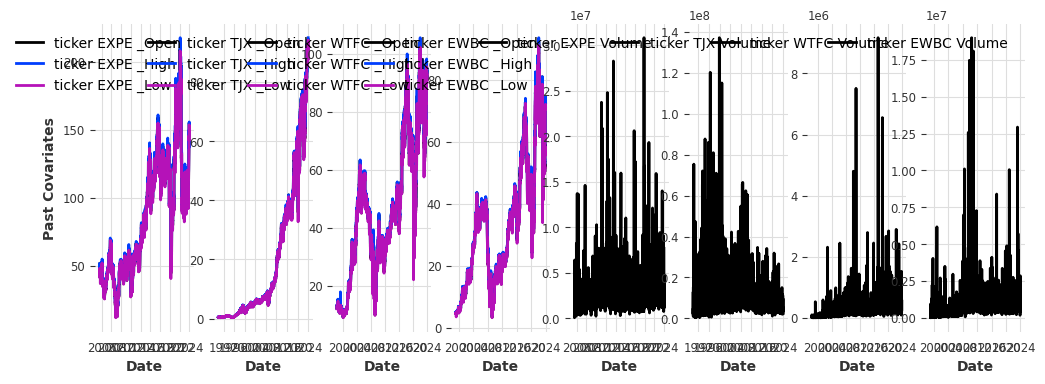

In [533]:
import matplotlib.pyplot as plt


n_plot_samples = 4
# plot sample of past covariates
fig, axes = plt.subplots(nrows=1, ncols=n_plot_samples*2, figsize=(12, 4))
for i,t in enumerate(past_covariates.keys()):
    if i < n_plot_samples:
        print(f'{t} past covariates components: {past_covariates[t].columns}')
        past_covariates[t].drop_columns(['Volume']).plot(label=f'ticker {t} ', ax=axes[i])
        past_covariates[t].univariate_component('Volume').plot(label=f'ticker {t} Volume ', ax=axes[n_plot_samples+i])

axes[0].set_ylabel('Past Covariates')


Stack broad market indicators to past covariates

In [534]:
broad_market_df = pd.read_csv('data/broad_market.csv.bz2', header=[0, 1], index_col=0)

# drop Close as redundand
broad_market_df = broad_market_df.drop(columns=['Close'], level=1)

# use a subset of indicies for testing
# broad_market_df = broad_market_df[(broad_market_df.columns[:1])]

#flatten column hierarchy so Darts can use as covariate series
broad_market_df.columns = [f'{i}_{j}' for i, j in broad_market_df.columns]

# CBOE VIX volatility, DYX USD and TNT 10Y Treasury indices do not have meaningful values for Volume
broad_market_df = broad_market_df.drop(columns=['^VIX_Volume', 'DX-Y.NYB_Volume', '^TNX_Volume'])

# fix datetime index type issue
# https://stackoverflow.com/questions/48248239/pandas-how-to-convert-rangeindex-into-datetimeindex
broad_market_df.index = pd.to_datetime(broad_market_df.index)

broad_market_df

,^R2ESC_Open,^R2ESC_High,^R2ESC_Low,^R2ESC_Adj Close,^R2ESC_Volume,^NDX_Open,^NDX_High,^NDX_Low,^NDX_Adj Close,^NDX_Volume,...,^NDXE_Adj Close,^NDXE_Volume,^VIX_Open,^VIX_High,^VIX_Low,^VIX_Adj Close,^TNX_Open,^TNX_High,^TNX_Low,^TNX_Adj Close
Date,,,,,,,,,,,,,,,,,,,,,
1927-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-05,NaN,NaN,NaN,NaN,NaN,16281.740234,16415.390625,16249.190430,16305.980469,5.232820e+09,...,6950.770020,757800.0,14.24,14.58,13.29,13.35,4.038,4.099,3.953,4.042
2024-01-08,NaN,NaN,NaN,NaN,NaN,16354.219727,16655.230469,16349.389648,16649.869141,6.337770e+09,...,7078.250000,838300.0,14.00,14.18,13.02,13.08,4.059,4.063,3.966,4.002
2024-01-09,NaN,NaN,NaN,NaN,NaN,16531.960938,16710.880859,16513.730469,16678.699219,5.068410e+09,...,7078.229980,800400.0,13.20,13.45,12.74,12.76,4.047,4.053,3.996,4.019


In [535]:
broad_market_series = TimeSeries.from_dataframe(broad_market_df, freq='B')
broad_market_series = broad_market_series.slice(train_date_start, broad_market_series.end_time())
broad_market_series

<TimeSeries (DataArray) (Date: 8879, component: 42, sample: 1)>
array([[[           nan],
        [           nan],
        [           nan],
        ...,
        [           nan],
        [           nan],
        [           nan]],

       [[           nan],
        [           nan],
        [           nan],
        ...,
        [7.94000006e+00],
        [7.94000006e+00],
        [7.94000006e+00]],

       [[           nan],
        [           nan],
        [           nan],
        ...,
...
        ...,
        [4.05299997e+00],
        [3.99600005e+00],
        [4.01900005e+00]],

       [[           nan],
        [           nan],
        [           nan],
        ...,
        [4.03800011e+00],
        [3.98499990e+00],
        [4.03000021e+00]],

       [[4.28342090e+03],
        [4.28342090e+03],
        [4.21256982e+03],
        ...,
        [4.06799984e+00],
        [3.97300005e+00],
        [3.97700000e+00]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1990-01-01 1990-01-02 ... 2024-01-11
  * component  (component) object '^R2ESC_Open' ... '^TNX_Adj Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [536]:
broad_market_series.gaps()


,gap_start,gap_end,gap_size
0,1999-04-02,1999-04-02,1
1,1999-05-31,1999-05-31,1
2,2000-04-21,2000-04-21,1
3,2000-05-29,2000-05-29,1
4,2000-09-04,2000-09-04,1
...,...,...,...
188,2023-07-04,2023-07-04,1
189,2023-09-04,2023-09-04,1
190,2023-11-23,2023-11-23,1
191,2023-12-25,2023-12-25,1


In [537]:

filler = MissingValuesFiller()

series_filled = filler.transform(broad_market_series)
series_filled.gaps()

,gap_start,gap_end


In [538]:
broad_market_series = series_filled


In [539]:
# scale series to avoid exploding gradients
#bm_scaler = Scaler(verbose=True, n_jobs=-1)
#for c in broad_market_series.columns:
#    broad_market_series[c] = 
#broad_market_series = bm_scaler.fit_transform(series=broad_market_series)
#broad_market_series

In [540]:
print(f'past covariates without broad market indicies: {past_covariates[t].components}')


past covariates without broad market indicies: Index(['Open', 'High', 'Low', 'Volume'], dtype='object', name='component')


In [541]:
for t, covs in past_covariates.items():
    bm_sliced = broad_market_series.slice_intersect(covs)
    past_covariates[t] = covs.stack(bm_sliced)
    print(f'past covariates for {t} including broad market indicies: {past_covariates[t].components}')


past covariates for EXPE including broad market indicies: Index(['Open', 'High', 'Low', 'Volume', '^R2ESC_Open', '^R2ESC_High',
       '^R2ESC_Low', '^R2ESC_Adj Close', '^R2ESC_Volume', '^NDX_Open',
       '^NDX_High', '^NDX_Low', '^NDX_Adj Close', '^NDX_Volume', '^RUT_Open',
       '^RUT_High', '^RUT_Low', '^RUT_Adj Close', '^RUT_Volume', '^SPX_Open',
       '^SPX_High', '^SPX_Low', '^SPX_Adj Close', '^SPX_Volume', '^SPXEW_Open',
       '^SPXEW_High', '^SPXEW_Low', '^SPXEW_Adj Close', '^SPXEW_Volume',
       'DX-Y.NYB_Open', 'DX-Y.NYB_High', 'DX-Y.NYB_Low', 'DX-Y.NYB_Adj Close',
       '^NDXE_Open', '^NDXE_High', '^NDXE_Low', '^NDXE_Adj Close',
       '^NDXE_Volume', '^VIX_Open', '^VIX_High', '^VIX_Low', '^VIX_Adj Close',
       '^TNX_Open', '^TNX_High', '^TNX_Low', '^TNX_Adj Close'],
      dtype='object', name='component')
past covariates for TJX including broad market indicies: Index(['Open', 'High', 'Low', 'Volume', '^R2ESC_Open', '^R2ESC_High',
       '^R2ESC_Low', '^R2ESC_Adj Clo

In [542]:
print(f'past covariates with broad market indicies: {past_covariates[t].components}')
print(f'past covariates without broad market indicies: {past_covariates[t][0]}')


past covariates with broad market indicies: Index(['Open', 'High', 'Low', 'Volume', '^R2ESC_Open', '^R2ESC_High',
       '^R2ESC_Low', '^R2ESC_Adj Close', '^R2ESC_Volume', '^NDX_Open',
       '^NDX_High', '^NDX_Low', '^NDX_Adj Close', '^NDX_Volume', '^RUT_Open',
       '^RUT_High', '^RUT_Low', '^RUT_Adj Close', '^RUT_Volume', '^SPX_Open',
       '^SPX_High', '^SPX_Low', '^SPX_Adj Close', '^SPX_Volume', '^SPXEW_Open',
       '^SPXEW_High', '^SPXEW_Low', '^SPXEW_Adj Close', '^SPXEW_Volume',
       'DX-Y.NYB_Open', 'DX-Y.NYB_High', 'DX-Y.NYB_Low', 'DX-Y.NYB_Adj Close',
       '^NDXE_Open', '^NDXE_High', '^NDXE_Low', '^NDXE_Adj Close',
       '^NDXE_Volume', '^VIX_Open', '^VIX_High', '^VIX_Low', '^VIX_Adj Close',
       '^TNX_Open', '^TNX_High', '^TNX_Low', '^TNX_Adj Close'],
      dtype='object', name='component')
past covariates without broad market indicies: <TimeSeries (DataArray) (Date: 1, component: 46, sample: 1)>
array([[[7.33333302e+00],
        [7.83333302e+00],
        [7.333333

Prepare Future Covariates

In [543]:

future_covariates = {t: ticker_series[t].univariate_component('holidays') for t in ticker_series.keys()}
future_covariates

{'EXPE': <TimeSeries (DataArray) (Date: 4821, component: 1, sample: 1)>
 array([[[0.]],
 
        [[0.]],
 
        [[0.]],
 
        ...,
 
        [[0.]],
 
        [[0.]],
 
        [[0.]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2005-07-21 2005-07-22 ... 2024-01-11
   * component  (component) object 'holidays'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'TJX': <TimeSeries (DataArray) (Date: 8879, component: 1, sample: 1)>
 array([[[1.]],
 
        [[0.]],
 
        [[0.]],
 
        ...,
 
        [[0.]],
 
        [[0.]],
 
        [[0.]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 1990-01-01 1990-01-02 ... 2024-01-11
   * component  (component) object 'holidays'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'WTFC': <TimeSeries (DataArray) (Date: 6716, component: 1, sample: 1)>
 array([[[0.]],
 
        [[0.]],
 
       

Add sales and earnings calendar (past and forward looking) as future covariates

In [580]:
import pandas as pd

earnings_loaded_df = pd.read_csv('data/earnings_calendar.csv.bz2', index_col=['symbol', 'date'])
print(earnings_loaded_df)

                       eps  epsEstimated time      revenue  revenueEstimated  \
symbol date                                                                    
AAON   2024-11-04      NaN           NaN  amc          NaN               NaN   
       2024-08-01      NaN           NaN  amc          NaN               NaN   
       2024-05-02      NaN           NaN  amc          NaN               NaN   
       2024-02-26      NaN          0.53  bmo          NaN       294360000.0   
       2023-11-06   0.6400          0.55  amc  311970000.0       294360000.0   
...                    ...           ...  ...          ...               ...   
AER    2006-03-31   0.4480           NaN  bmo  200932000.0               NaN   
       2005-12-31   0.2664           NaN  bmo  151717000.0               NaN   
       2005-09-30  28.3100           NaN  bmo  123270000.0               NaN   
       2005-06-30  28.3100           NaN  bmo  123270000.0               NaN   
       2005-03-31  28.3100           NaN

In [581]:
assert not earnings_loaded_df.index.duplicated().any()

In [582]:
# check if data for a given symbol was saved and loaded as expected
earnings_loaded_df.loc[['AAON']]


eps  epsEstimated time      revenue  revenueEstimated  \
symbol date                                                                    
AAON   2024-11-04      NaN           NaN  amc          NaN               NaN   
       2024-08-01      NaN           NaN  amc          NaN               NaN   
       2024-05-02      NaN           NaN  amc          NaN               NaN   
       2024-02-26      NaN          0.53  bmo          NaN       294360000.0   
       2023-11-06  0.64000          0.55  amc  311970000.0       294360000.0   
...                    ...           ...  ...          ...               ...   
       1991-03-31 -0.00159           NaN  bmo    5700000.0               NaN   
       1990-12-31  0.00352           NaN  bmo   36100000.0               NaN   
       1990-09-30  0.00703           NaN  bmo   10100000.0               NaN   
       1990-06-30  0.00703           NaN  bmo    9300000.0               NaN   
       1990-03-31  0.00352           NaN  bmo    8200000.0               NaN   

                  updatedFromDate fiscalDateEnding  
symbol date                                         
AAON   2024-11-04      2024-01-12       2024-09-30  
       2024-08-01      2024-01-12       2024-06-30  
       2024-05-02      2024-01-12       2024-03-30  
       2024-02-26      2024-01-12       2023-12-30  
       2023-11-06      2024-01-12       2023-09-30  
...                           ...              ...  
       1991-03-31      2023-12-04       1991-03-31  
       1990-12-31      2023-12-04       1990-12-31  
       1990-09-30      2023-12-04       1990-09-30  
       1990-06-30      2023-12-04       1990-06-30  
       1990-03-31      2023-12-04       1990-03-31  

[138 rows x 7 columns]

In [583]:
# convert date strings to numerical representation
ufd = pd.to_datetime(earnings_loaded_df['updatedFromDate'])
ufd_year = ufd.dt.year
ufd_month = ufd.dt.month
ufd_day = ufd.dt.day

earn_n_cols = len(earnings_loaded_df.columns)
earnings_loaded_df.insert(loc=earn_n_cols, column='updatedFromDate_year', value=ufd_year)
earnings_loaded_df.insert(loc=earn_n_cols, column='updatedFromDate_month', value=ufd_month)
earnings_loaded_df.insert(loc=earn_n_cols, column='updatedFromDate_day', value=ufd_day)
earnings_loaded_df.pop('updatedFromDate')


symbol  date      
AAON    2024-11-04    2024-01-12
        2024-08-01    2024-01-12
        2024-05-02    2024-01-12
        2024-02-26    2024-01-12
        2023-11-06    2024-01-12
                         ...    
AER     2006-03-31    2023-12-04
        2005-12-31    2023-12-04
        2005-09-30    2023-12-04
        2005-06-30    2023-12-04
        2005-03-31    2023-12-04
Name: updatedFromDate, Length: 579, dtype: object

In [584]:
earnings_loaded_df

eps  epsEstimated time      revenue  revenueEstimated  \
symbol date                                                                    
AAON   2024-11-04      NaN           NaN  amc          NaN               NaN   
       2024-08-01      NaN           NaN  amc          NaN               NaN   
       2024-05-02      NaN           NaN  amc          NaN               NaN   
       2024-02-26      NaN          0.53  bmo          NaN       294360000.0   
       2023-11-06   0.6400          0.55  amc  311970000.0       294360000.0   
...                    ...           ...  ...          ...               ...   
AER    2006-03-31   0.4480           NaN  bmo  200932000.0               NaN   
       2005-12-31   0.2664           NaN  bmo  151717000.0               NaN   
       2005-09-30  28.3100           NaN  bmo  123270000.0               NaN   
       2005-06-30  28.3100           NaN  bmo  123270000.0               NaN   
       2005-03-31  28.3100           NaN  bmo  123270000.0               NaN   

                  fiscalDateEnding  updatedFromDate_day  \
symbol date                                               
AAON   2024-11-04       2024-09-30                   12   
       2024-08-01       2024-06-30                   12   
       2024-05-02       2024-03-30                   12   
       2024-02-26       2023-12-30                   12   
       2023-11-06       2023-09-30                   12   
...                            ...                  ...   
AER    2006-03-31       2006-03-31                    4   
       2005-12-31       2005-12-31                    4   
       2005-09-30       2005-09-30                    4   
       2005-06-30       2005-06-30                    4   
       2005-03-31       2005-03-31                    4   

                   updatedFromDate_month  updatedFromDate_year  
symbol date                                                     
AAON   2024-11-04                      1                  2024  
       2024-08-01                      1                  2024  
       2024-05-02                      1                  2024  
       2024-02-26                      1                  2024  
       2023-11-06                      1                  2024  
...                                  ...                   ...  
AER    2006-03-31                     12                  2023  
       2005-12-31                     12                  2023  
       2005-09-30                     12                  2023  
       2005-06-30                     12                  2023  
       2005-03-31                     12                  2023  

[579 rows x 9 columns]

In [585]:
# convert date strings to numerical representation
fde = pd.to_datetime(earnings_loaded_df['fiscalDateEnding'])
fde_year = ufd.dt.year
fde_month = ufd.dt.month
fde_day = ufd.dt.day

earn_n_cols = len(earnings_loaded_df.columns)
earnings_loaded_df.insert(loc=earn_n_cols, column='fiscalDateEnding_year', value=fde_year)
earnings_loaded_df.insert(loc=earn_n_cols, column='fiscalDateEnding_month', value=fde_month)
earnings_loaded_df.insert(loc=earn_n_cols, column='fiscalDateEnding_day', value=fde_day)
earnings_loaded_df.pop('fiscalDateEnding')


symbol  date      
AAON    2024-11-04    2024-09-30
        2024-08-01    2024-06-30
        2024-05-02    2024-03-30
        2024-02-26    2023-12-30
        2023-11-06    2023-09-30
                         ...    
AER     2006-03-31    2006-03-31
        2005-12-31    2005-12-31
        2005-09-30    2005-09-30
        2005-06-30    2005-06-30
        2005-03-31    2005-03-31
Name: fiscalDateEnding, Length: 579, dtype: object

In [586]:
earnings_loaded_df

eps  epsEstimated time      revenue  revenueEstimated  \
symbol date                                                                    
AAON   2024-11-04      NaN           NaN  amc          NaN               NaN   
       2024-08-01      NaN           NaN  amc          NaN               NaN   
       2024-05-02      NaN           NaN  amc          NaN               NaN   
       2024-02-26      NaN          0.53  bmo          NaN       294360000.0   
       2023-11-06   0.6400          0.55  amc  311970000.0       294360000.0   
...                    ...           ...  ...          ...               ...   
AER    2006-03-31   0.4480           NaN  bmo  200932000.0               NaN   
       2005-12-31   0.2664           NaN  bmo  151717000.0               NaN   
       2005-09-30  28.3100           NaN  bmo  123270000.0               NaN   
       2005-06-30  28.3100           NaN  bmo  123270000.0               NaN   
       2005-03-31  28.3100           NaN  bmo  123270000.0               NaN   

                   updatedFromDate_day  updatedFromDate_month  \
symbol date                                                     
AAON   2024-11-04                   12                      1   
       2024-08-01                   12                      1   
       2024-05-02                   12                      1   
       2024-02-26                   12                      1   
       2023-11-06                   12                      1   
...                                ...                    ...   
AER    2006-03-31                    4                     12   
       2005-12-31                    4                     12   
       2005-09-30                    4                     12   
       2005-06-30                    4                     12   
       2005-03-31                    4                     12   

                   updatedFromDate_year  fiscalDateEnding_day  \
symbol date                                                     
AAON   2024-11-04                  2024                    12   
       2024-08-01                  2024                    12   
       2024-05-02                  2024                    12   
       2024-02-26                  2024                    12   
       2023-11-06                  2024                    12   
...                                 ...                   ...   
AER    2006-03-31                  2023                     4   
       2005-12-31                  2023                     4   
       2005-09-30                  2023                     4   
       2005-06-30                  2023                     4   
       2005-03-31                  2023                     4   

                   fiscalDateEnding_month  fiscalDateEnding_year  
symbol date                                                       
AAON   2024-11-04                       1                   2024  
       2024-08-01                       1                   2024  
       2024-05-02                       1                   2024  
       2024-02-26                       1                   2024  
       2023-11-06                       1                   2024  
...                                   ...                    ...  
AER    2006-03-31                      12                   2023  
       2005-12-31                      12                   2023  
       2005-09-30                      12                   2023  
       2005-06-30                      12                   2023  
       2005-03-31                      12                   2023  

[579 rows x 11 columns]

In [587]:
# convert earnings reporting time - Before Market Open / After Market Close - categories to numerical representation
earnings_loaded_df['time'] = earnings_loaded_df['time'].replace(['bmo', 'amc', '--'],
                        [0, 1, -1], inplace=False).astype('int32')



In [588]:
earnings_loaded_df.loc[earnings_loaded_df['time'] == '--']

,,eps,epsEstimated,time,revenue,revenueEstimated,updatedFromDate_day,updatedFromDate_month,updatedFromDate_year,fiscalDateEnding_day,fiscalDateEnding_month,fiscalDateEnding_year
symbol,date,,,,,,,,,,,


In [589]:
earnings_loaded_df

eps  epsEstimated  time      revenue  revenueEstimated  \
symbol date                                                                     
AAON   2024-11-04      NaN           NaN     1          NaN               NaN   
       2024-08-01      NaN           NaN     1          NaN               NaN   
       2024-05-02      NaN           NaN     1          NaN               NaN   
       2024-02-26      NaN          0.53     0          NaN       294360000.0   
       2023-11-06   0.6400          0.55     1  311970000.0       294360000.0   
...                    ...           ...   ...          ...               ...   
AER    2006-03-31   0.4480           NaN     0  200932000.0               NaN   
       2005-12-31   0.2664           NaN     0  151717000.0               NaN   
       2005-09-30  28.3100           NaN     0  123270000.0               NaN   
       2005-06-30  28.3100           NaN     0  123270000.0               NaN   
       2005-03-31  28.3100           NaN     0  123270000.0               NaN   

                   updatedFromDate_day  updatedFromDate_month  \
symbol date                                                     
AAON   2024-11-04                   12                      1   
       2024-08-01                   12                      1   
       2024-05-02                   12                      1   
       2024-02-26                   12                      1   
       2023-11-06                   12                      1   
...                                ...                    ...   
AER    2006-03-31                    4                     12   
       2005-12-31                    4                     12   
       2005-09-30                    4                     12   
       2005-06-30                    4                     12   
       2005-03-31                    4                     12   

                   updatedFromDate_year  fiscalDateEnding_day  \
symbol date                                                     
AAON   2024-11-04                  2024                    12   
       2024-08-01                  2024                    12   
       2024-05-02                  2024                    12   
       2024-02-26                  2024                    12   
       2023-11-06                  2024                    12   
...                                 ...                   ...   
AER    2006-03-31                  2023                     4   
       2005-12-31                  2023                     4   
       2005-09-30                  2023                     4   
       2005-06-30                  2023                     4   
       2005-03-31                  2023                     4   

                   fiscalDateEnding_month  fiscalDateEnding_year  
symbol date                                                       
AAON   2024-11-04                       1                   2024  
       2024-08-01                       1                   2024  
       2024-05-02                       1                   2024  
       2024-02-26                       1                   2024  
       2023-11-06                       1                   2024  
...                                   ...                    ...  
AER    2006-03-31                      12                   2023  
       2005-12-31                      12                   2023  
       2005-09-30                      12                   2023  
       2005-06-30                      12                   2023  
       2005-03-31                      12                   2023  

[579 rows x 11 columns]

In [ ]:
from darts import TimeSeries

type(earnings_loaded_df.index)

pandas.core.indexes.multi.MultiIndex

In [ ]:
earnings_loaded_df.index.names

FrozenList(['symbol', 'date'])

In [ ]:
earnings_loaded_df.dtypes

eps                       float64
epsEstimated              float64
time                        int32
revenue                   float64
revenueEstimated          float64
updatedFromDate_day         int32
updatedFromDate_month       int32
updatedFromDate_year        int32
fiscalDateEnding_day        int32
fiscalDateEnding_month      int32
fiscalDateEnding_year       int32
dtype: object

In [590]:
tickers = earnings_loaded_df.index.get_level_values('symbol').unique()
t_earn_series = {}
for t in tickers:
    t_earn = earnings_loaded_df.loc[[t]]
    t_earn = t_earn.droplevel('symbol')
    t_earn.index = pd.to_datetime(t_earn.index)
    print(f'index type for {t}: {type(t_earn.index)}')
    assert not t_earn.index.duplicated().any()
    print(f'{t} earnings: \n{t_earn}')
    tes = TimeSeries.from_dataframe(t_earn, fillna_value=-1, freq='D', fill_missing_dates=True)
    assert len(tes.gaps()) == 0
    t_earn_series[t] = tes


index type for AAON: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
AAON earnings: 
                eps  epsEstimated  time      revenue  revenueEstimated  \
date                                                                     
2024-11-04      NaN           NaN     1          NaN               NaN   
2024-08-01      NaN           NaN     1          NaN               NaN   
2024-05-02      NaN           NaN     1          NaN               NaN   
2024-02-26      NaN          0.53     0          NaN       294360000.0   
2023-11-06  0.64000          0.55     1  311970000.0       294360000.0   
...             ...           ...   ...          ...               ...   
1991-03-31 -0.00159           NaN     0    5700000.0               NaN   
1990-12-31  0.00352           NaN     0   36100000.0               NaN   
1990-09-30  0.00703           NaN     0   10100000.0               NaN   
1990-06-30  0.00703           NaN     0    9300000.0               NaN   
1990-03-31  0.00352  

In [ ]:
t_earn_series

<TimeSeries (DataArray) (date: 7147, component: 11, sample: 1)>
array([[[ 2.831e+01],
        [-1.000e+00],
        [ 0.000e+00],
        ...,
        [ 4.000e+00],
        [ 1.200e+01],
        [ 2.023e+03]],

       [[-1.000e+00],
        [-1.000e+00],
        [-1.000e+00],
        ...,
        [-1.000e+00],
        [-1.000e+00],
        [-1.000e+00]],

       [[-1.000e+00],
        [-1.000e+00],
        [-1.000e+00],
        ...,
...
        ...,
        [-1.000e+00],
        [-1.000e+00],
        [-1.000e+00]],

       [[-1.000e+00],
        [-1.000e+00],
        [-1.000e+00],
        ...,
        [-1.000e+00],
        [-1.000e+00],
        [-1.000e+00]],

       [[-1.000e+00],
        [-1.000e+00],
        [ 0.000e+00],
        ...,
        [ 1.200e+01],
        [ 1.000e+00],
        [ 2.024e+03]]])
Coordinates:
  * date       (date) datetime64[ns] 2005-03-31 2005-04-01 ... 2024-10-23
  * component  (component) object 'eps' ... 'fiscalDateEnding_year'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Prepare train and validation splits

In [544]:
val_start = pd.Timestamp('2023-05-05')
train_series = {}
val_series = {}
past_covariates_train = {}
past_covariates_val = {}

for t, target in target_series.items():
    train, val = target.split_before(val_start)
    # there should be no gaps in the training data
    assert(len(train.gaps().index) == 0)
    train_series[t] = train
    val_series[t] = val
    past_train, past_val = past_covariates[t].split_before(val_start)
    # there should be no gaps in the training data
    assert(len(past_train.gaps().index) == 0)
    past_covariates_train[t] = past_train 
    past_covariates_val = past_val



In [545]:
train_series, val_series

({'EXPE': <TimeSeries (DataArray) (Date: 4641, component: 1, sample: 1)>
  array([[[31.64082336]],
  
         [[32.74734879]],
  
         [[31.93062401]],
  
         ...,
  
         [[93.23999786]],
  
         [[90.56999969]],
  
         [[89.16999817]]])
  Coordinates:
    * Date       (Date) datetime64[ns] 2005-07-21 2005-07-22 ... 2023-05-04
    * component  (component) object 'Adj Close'
  Dimensions without coordinates: sample
  Attributes:
      static_covariates:  None
      hierarchy:          None,
  'TJX': <TimeSeries (DataArray) (Date: 8699, component: 1, sample: 1)>
  array([[[ 0.29771961]],
  
         [[ 0.29892492]],
  
         [[ 0.30615717]],
  
         ...,
  
         [[77.32411194]],
  
         [[76.92880249]],
  
         [[76.16781616]]])
  Coordinates:
    * Date       (Date) datetime64[ns] 1990-01-01 1990-01-02 ... 2023-05-04
    * component  (component) object 'Adj Close'
  Dimensions without coordinates: sample
  Attributes:
      static_covariates:  

In [546]:
past_covariates_train, past_covariates_val

({'EXPE': <TimeSeries (DataArray) (Date: 4641, component: 46, sample: 1)>
  array([[[48.22000122],
          [49.20000076],
          [47.84000015],
          ...,
          [ 4.28900003],
          [ 4.19899988],
          [ 4.28200006]],
  
         [[49.24000168],
          [49.79999924],
          [47.90000153],
          ...,
          [ 4.26200008],
          [ 4.21299982],
          [ 4.22300005]],
  
         [[49.79999924],
          [49.79999924],
          [48.29999924],
          ...,
  ...
          ...,
          [ 3.55900002],
          [ 3.42400002],
          [ 3.43899989]],
  
         [[93.        ],
          [93.41000366],
          [90.19999695],
          ...,
          [ 3.42400002],
          [ 3.3670001 ],
          [ 3.40300012]],
  
         [[89.70999908],
          [90.31999969],
          [87.94000244],
          ...,
          [ 3.41100001],
          [ 3.296     ],
          [ 3.35100007]]])
  Coordinates:
    * Date       (Date) datetime64[ns] 2005-07-

Plot data splits

Text(0, 0.5, 'Target Series')

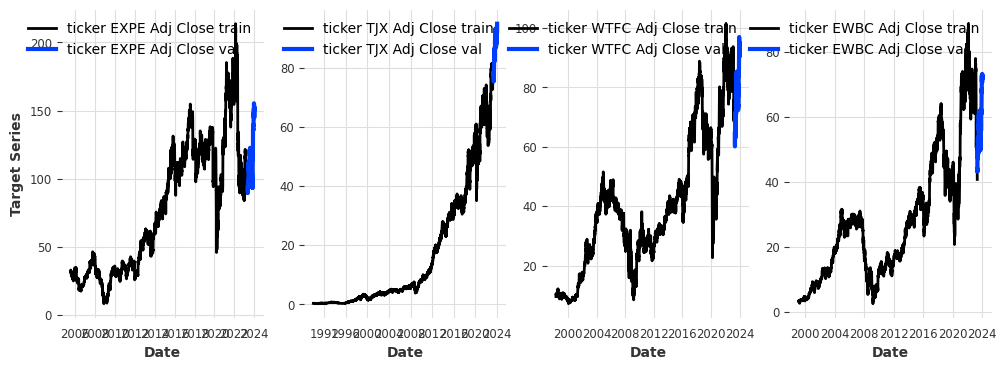

In [547]:
import matplotlib.pyplot as plt

# plot sample of target series
fig, axes = plt.subplots(nrows=1, ncols=n_plot_samples, figsize=(12, 4))
for i,t in enumerate(target_series.keys()):
    if i > n_plot_samples-1:
        break
    train_series[t].plot(label=f'ticker {t} {train_series[t].columns[0]} train', ax=axes[i])
    val_series[t].plot(label=f'ticker {t} {train_series[t].columns[0]} val', lw=3, ax=axes[i])

axes[0].set_ylabel('Target Series')


Show seasonalities

Text(0, 0.5, 'Seasonality')

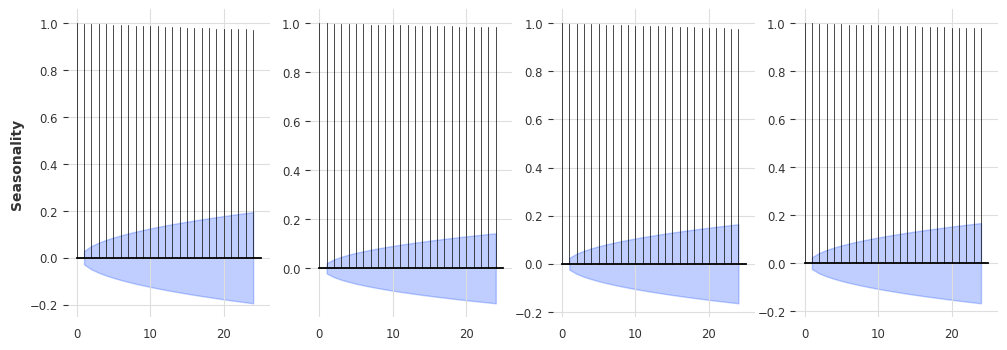

In [548]:
from darts.utils.statistics import plot_acf, check_seasonality

# plot sample of target series
fig, axes = plt.subplots(nrows=1, ncols=n_plot_samples, figsize=(12, 4))
for i,t in enumerate(target_series.keys()):
    if i == n_plot_samples:
        break
    plot_acf(train_series[t], alpha=0.05, axis=axes[i])

axes[0].set_ylabel('Seasonality')



Train our current working model

Prepare Encoders that Darts will automatically use for training and inference

In [549]:
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.dataprocessing import Pipeline
# 
scaler = Scaler(verbose=True, n_jobs=-1)

# darts encoder examples: https://unit8co.github.io/darts/generated_api/darts.dataprocessing.encoders.encoders.html#
encoders = {
    'cyclic': {'future': ['dayofweek', 'month', 'quarter']},
    "datetime_attribute": {"future": ["dayofweek", "month", "quarter", "year"]}, 
    'position': {'past': ['relative'], 'future': ['relative']},
    'custom': {'future': [lambda idx: (idx.year % 4)]},  # signal proximity to US election years, which is known to have significance to market cycles.
    # "transformer": scaler
}



In [550]:
train_history = 252*2 # 252 days in a year with market data
pred_horizon = 21*2 # 21 days in a month with market data
n_epochs = 20 # model training epochs

Model hyperparameter selection

In [551]:
# based on Darts template: https://unit8co.github.io/darts/examples/18-TiDE-examples.html#Model-Parameter-Setup

optimizer_kwargs = {
    "lr": 1e-3,
}

# PyTorch Lightning Trainer arguments
pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "max_epochs": 200,
    "accelerator": "auto",
    "callbacks": [],
}

# learning rate scheduler
lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
lr_scheduler_kwargs = {
    "gamma": 0.999,
}

# early stopping (needs to be reset for each model later on)
# this setting stops training once the the validation loss has not decreased by more than 1e-3 for 10 epochs
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 10,
    "min_delta": 1e-3,
    "mode": "min",
}

#
common_model_args = {
    # "input_chunk_length": 12,  # lookback window
    # "output_chunk_length": 12,  # forecast/lookahead window
    "optimizer_kwargs": optimizer_kwargs,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "lr_scheduler_cls": lr_scheduler_cls,
    "lr_scheduler_kwargs": lr_scheduler_kwargs,
    # "likelihood": None,  # use a likelihood for probabilistic forecasts
    # "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
    # "force_reset": True,
    "batch_size": 256,
    "random_state": 42,
}

In [552]:
from darts.models import TiDEModel

from darts.utils.likelihood_models import QuantileRegression

saved_model_name = 'data/canswim_model.pt'
model = None

# If available, load the saved model state that performed best on validation set
try:
  print('Loading saved model')
  model = TiDEModel.load(saved_model_name)  
except Exception as e:
  print('Error loading saved model:', e)
  print('Creating a new model')
  model = TiDEModel(
      **common_model_args,
      input_chunk_length=train_history,
      output_chunk_length=pred_horizon,
      use_layer_norm=True,
      add_encoders=None, # encoders,
      dropout=0.1,
      n_epochs=n_epochs,
      use_reversible_instance_norm=True,
      likelihood=QuantileRegression(quantiles=[0.01, 0.05, 0.2, 0.5, 0.8, 0.95, 0.99]),
      model_name=saved_model_name,
  )
  


Loading saved model


In [553]:
from darts.models import RegressionModel
from darts.models.forecasting.forecasting_model import GlobalForecastingModel

# when True, multiple time series are supported
supports_multi_ts = issubclass(model.__class__, GlobalForecastingModel)
supports_multi_ts

True

In [554]:
targets_list = [series for ticker, series in sorted(target_series.items())]
target_train_list = [series for ticker, series in sorted(train_series.items())]
print(len(target_train_list))
target_val_list = [series for ticker, series in sorted(val_series.items())]
print(len(target_train_list))
past_cov_list = [series for ticker, series in sorted(past_covariates_train.items())]
print(len(past_cov_list))
future_cov_list = [series for ticker, series in sorted(future_covariates.items())]
print(len(future_cov_list))


10
10
10
10


In [555]:
type(target_train_list[0])

darts.timeseries.TimeSeries

In [556]:
print(len(target_train_list[0].time_index))
print(len(past_cov_list[0].time_index))
print(len(future_cov_list[0].time_index))


2057
2057
2237


In [557]:
target_train_list[0].pd_dataframe()

component,Adj Close
Date,
2015-06-17,22.750000
2015-06-18,22.750000
2015-06-19,22.750000
2015-06-22,22.750000
2015-06-23,22.750000
...,...
2023-04-28,225.479996
2023-05-01,222.070007
2023-05-02,221.070007


In [558]:
target_train_list[0].start_time(), target_train_list[0].end_time()

(Timestamp('2015-06-17 00:00:00'), Timestamp('2023-05-04 00:00:00'))

In [559]:
past_cov_list[0].pd_dataframe()

component,Open,High,Low,Volume,^R2ESC_Open,^R2ESC_High,^R2ESC_Low,^R2ESC_Adj Close,^R2ESC_Volume,^NDX_Open,...,^NDXE_Adj Close,^NDXE_Volume,^VIX_Open,^VIX_High,^VIX_Low,^VIX_Adj Close,^TNX_Open,^TNX_High,^TNX_Low,^TNX_Adj Close
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-17,22.750000,22.750000,22.750000,100.0,4283.420898,4283.420898,4212.569824,4245.154785,0.0,4465.169922,...,2699.260010,0.0,14.660000,15.490000,14.070000,14.500000,2.331,2.403,2.306,2.306
2015-06-18,22.750000,22.750000,22.750000,100.0,4283.420898,4283.420898,4212.569824,4245.154785,0.0,4483.609863,...,2736.729980,0.0,14.030000,14.030000,12.540000,13.190000,2.304,2.381,2.288,2.351
2015-06-19,22.750000,22.750000,22.750000,0.0,4283.420898,4283.420898,4212.569824,4245.154785,0.0,4538.709961,...,2727.959961,0.0,13.350000,14.000000,12.960000,13.960000,2.317,2.317,2.260,2.267
2015-06-22,22.750000,22.750000,22.750000,200.0,4283.420898,4283.420898,4212.569824,4245.154785,0.0,4541.850098,...,2744.209961,0.0,13.420000,13.460000,12.430000,12.740000,2.317,2.369,2.285,2.360
2015-06-23,22.750000,22.750000,22.750000,0.0,4283.420898,4283.420898,4212.569824,4245.154785,0.0,4549.520020,...,2742.260010,0.0,12.500000,12.680000,11.930000,12.110000,2.389,2.429,2.367,2.409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-28,220.940002,227.080002,220.940002,248200.0,4283.420898,4283.420898,4212.569824,4245.154785,0.0,13139.349609,...,5989.450195,1066400.0,17.209999,17.650000,15.720000,15.780000,3.479,3.494,3.435,3.452
2023-05-01,224.789993,226.240005,220.949997,142800.0,4283.420898,4283.420898,4212.569824,4245.154785,0.0,13229.110352,...,5980.620117,828700.0,16.410000,16.620001,15.530000,16.080000,3.501,3.576,3.462,3.574
2023-05-02,219.399994,221.899994,216.977005,164100.0,4283.420898,4283.420898,4212.569824,4245.154785,0.0,13225.480469,...,5908.020020,901200.0,16.270000,19.809999,16.260000,17.780001,3.532,3.559,3.424,3.439


In [560]:
past_cov_list[0].start_time(), past_cov_list[0].end_time()

(Timestamp('2015-06-17 00:00:00'), Timestamp('2023-05-04 00:00:00'))

In [561]:
n_holidays = future_cov_list[0].pd_dataframe().sum()
n_holidays

component
holidays    90.0
dtype: float64

In [562]:
future_cov_list[0].start_time(), future_cov_list[0].end_time()

(Timestamp('2015-06-17 00:00:00'), Timestamp('2024-01-11 00:00:00'))

In [563]:
# train model
# for i in range(100):
model.fit(target_train_list, epochs=n_epochs, past_covariates=past_cov_list, future_covariates=future_cov_list, verbose=True, num_loader_workers=10, )
          # val_series=target_val_list[0]) # , val_future_covariates=future_cov_list[0]) 



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 2     
4 | past_cov_projection   | _ResidualBlock   | 6.7 K 
5 | future_cov_projection | _ResidualBlock   | 788   
6 | encoders              | Sequential       | 1.2 M 
7 | decoders              | Sequential       | 1.2 M 
8 | temporal_decoder      | _ResidualBlock   | 4.8 K 
9 | lookback_skip         | Linear           | 148 K 
-----------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.486    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


TiDEModel(num_encoder_layers=1, num_decoder_layers=1, decoder_output_dim=16, hidden_size=128, temporal_width_past=4, temporal_width_future=4, temporal_decoder_hidden=32, use_layer_norm=True, dropout=0.1, use_static_covariates=True, optimizer_kwargs={'lr': 0.001}, pl_trainer_kwargs={'gradient_clip_val': 1, 'max_epochs': 200, 'accelerator': 'auto', 'callbacks': []}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, lr_scheduler_kwargs={'gamma': 0.999}, batch_size=256, random_state=42, input_chunk_length=504, output_chunk_length=42, add_encoders=None, n_epochs=2, use_reversible_instance_norm=True, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), model_name=data/canswim_model.pt)

In [564]:
# save model checkpoint
model.save(saved_model_name)


In [565]:
# use probabilistic prediction
# see https://unit8co.github.io/darts/userguide/forecasting_overview.html#probabilistic-forecasts
pred = model.predict(pred_horizon, series=target_train_list, mc_dropout=True, num_samples=500, past_covariates=past_cov_list, future_covariates=future_cov_list)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [566]:
pred[0]

<TimeSeries (DataArray) (Date: 42, component: 1, sample: 500)>
array([[[213.22159892, 213.48894421, 205.11922964, ..., 204.72728418,
         204.67855419, 210.93980347]],

       [[210.50414519, 205.89964602, 208.64821017, ..., 222.5256943 ,
         211.20550971, 201.97013783]],

       [[209.53474328, 217.66340654, 215.04643834, ..., 211.21281327,
         215.10064183, 218.65644639]],

       ...,

       [[215.21304049, 231.15300284, 234.02134698, ..., 226.51632019,
         228.25966155, 220.13003026]],

       [[226.13446803, 218.66759704, 218.83820743, ..., 231.02892568,
         215.14842427, 233.7910582 ]],

       [[227.03742566, 227.72077787, 217.07828499, ..., 239.4615109 ,
         213.7329008 , 233.57670556]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2023-05-05 2023-05-08 ... 2023-07-03
  * component  (component) object 'Adj Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [567]:
pred[0].gaps()

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


,gap_start,gap_end


In [568]:
#pred2_series = target.slice(target.start_time(), val_start+pd.Timedelta(days=60))
#pred2 = model.predict(pred_horizon, series=pred2_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
#pred2

In [569]:
#pred3_series = target.slice(target.start_time(), pred2_series.end_time()+pd.Timedelta(days=60))
#pred3 = model.predict(pred_horizon, series=pred3_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
#pred3

In [570]:
#pred4_series = target.slice(target.start_time(), pred3_series.end_time()+pd.Timedelta(days=60))
#pred4 = model.predict(pred_horizon, series=pred4_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
#pred4

In [571]:
#pred5_series = target.slice(target.start_time(), val_start+pd.Timedelta(days=30))
#pred5 = model.predict(pred_horizon, series=pred5_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
#pred5

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


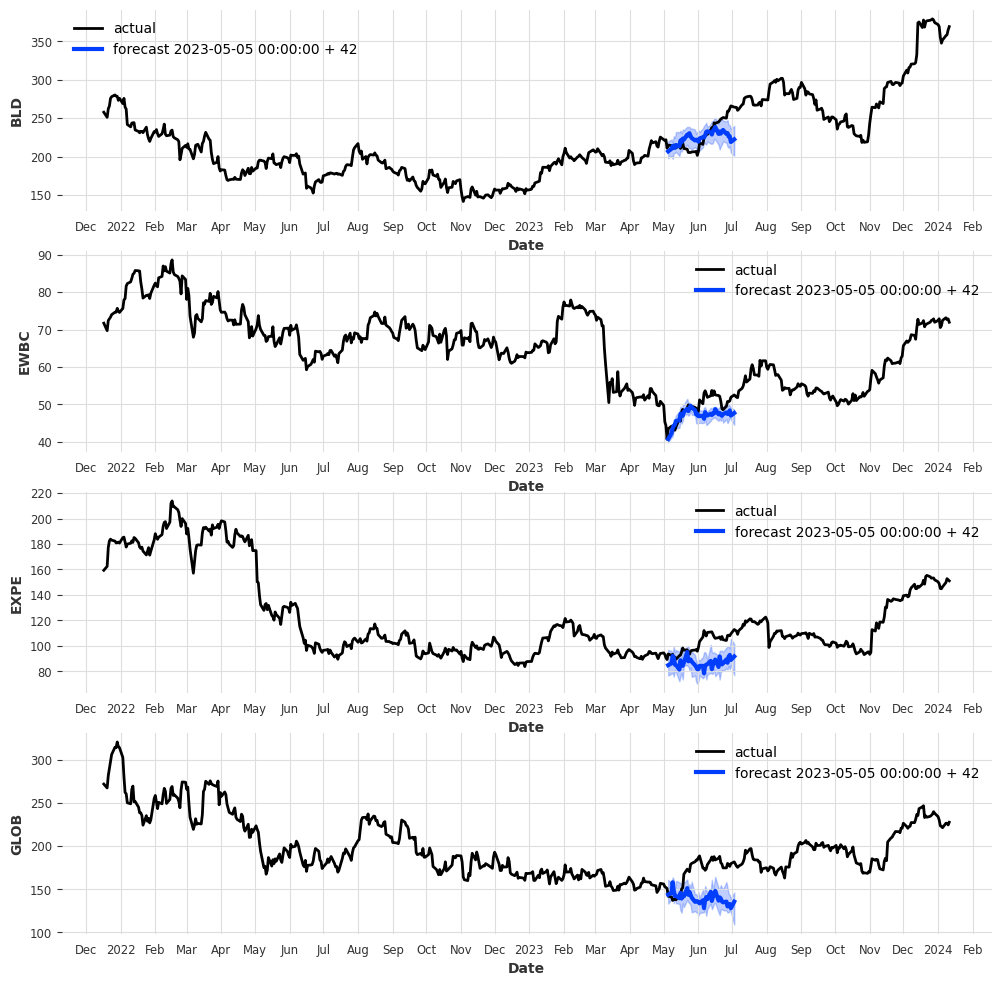

In [572]:
import matplotlib.dates as mdates

# select a reasonable range of train and val data points for convenient visualization of results
actual = {}

fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(12, 12))

for i,t in enumerate(sorted(train_series.keys())):
    if i < n_plot_samples:
        tsliced = target_series[t]
        actual[t] = tsliced.slice(val_start-pd.Timedelta(days=train_history), target.end_time())
        ax = actual[t].plot(label='actual', ax=axes[i])
        pred[i].plot(label=f'forecast {val_start} + {pred_horizon}', linewidth=3, ax=axes[i])
        #pred2.plot(label=f'forecast {pred2_series.end_time()} + {pred_horizon}')
        #pred3.plot(label=f'forecast {pred3_series.end_time()} + {pred_horizon}')
        #pred4.plot(label=f'forecast {pred4_series.end_time()} + {pred_horizon}')
        #pred5.plot(label=f'forecast {pred5_series.end_time()} + {pred_horizon}')
        plt.legend()

        # Major ticks every half year, minor ticks every month,
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(13)))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(True)
        ax.set_ylabel(f'{t}')




Backtest Model


Backtest model on the full range of test data

In [577]:
from darts.metrics import rmse

def eval_model(model=None, series=None, start=None, past_covariates=None, future_covariates=None, forecast_horizon=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the val portion of the flow series, with a forecast_horizon:
    backtest = model.historical_forecasts(series=series, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=start, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=forecast_horizon,
                                          overlap_end=True,
                                          num_samples=500, # probabilistic forecasting
                                          predict_kwargs={'mc_dropout': True, 'num_loader_workers': 10, 'n_jobs': -1}
                                          )
    
    return backtest


In [578]:
# set the forecast start at a time before the validation date in order to see 
# the difference between predicting on training vs validation data
# predicting up to the validate date should be near match to actuals
# whereas predicting on unseen validate data should have room for improvement
forecast_start = val_start-pd.Timedelta(days=120)
forecast_horizon = pred_horizon # pred_horizon

backtest = eval_model(model=model, series=targets_list, start=forecast_start, forecast_horizon=forecast_horizon, past_covariates=past_cov_list, future_covariates=future_cov_list)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


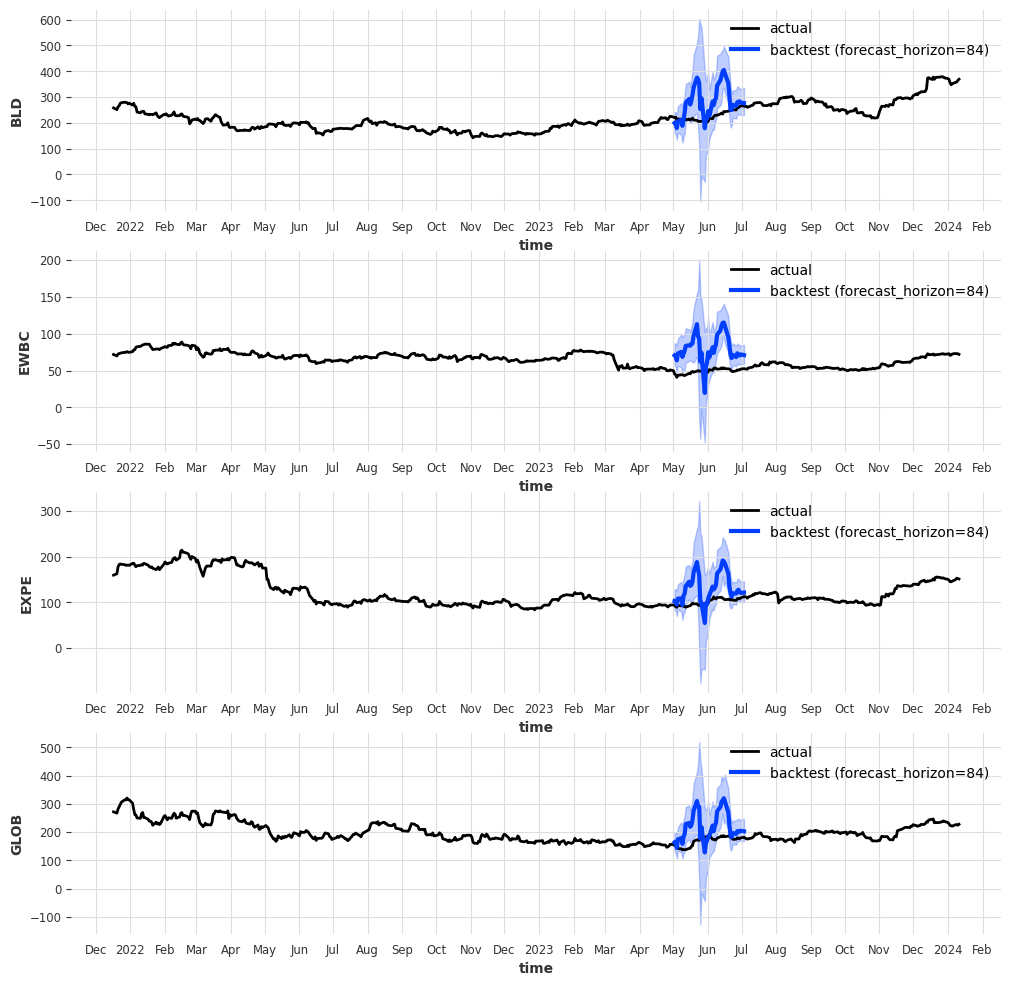

In [575]:

fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(12, 12))

for i,t in enumerate(sorted(train_series.keys())):
    if i < n_plot_samples:
        tsliced = target_series[t]
        actual[t] = tsliced.slice(val_start-pd.Timedelta(days=train_history), target.end_time())
        ax = actual[t].plot(label='actual', ax=axes[i])
        backtest[i].plot(label=f'backtest (forecast_horizon={forecast_horizon})', linewidth=3, ax=axes[i])
        plt.legend()

        # Major ticks every half year, minor ticks every month,
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(13)))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(True)
        ax.set_ylabel(f'{t}')







In [576]:
print('Backtest RMSE = {}'.format(rmse(target_train_list, backtest)))


Backtest RMSE = [27.290453768115242, 24.32166935391356, 9.447317786560387, 8.507879172054471, 6.0636153336098255, 1.4454505680072365, 14.946357110429393, 21.490207075687927, 5.067991771738563, 19.80495425046803]
